# Classification for Multiple Sclerosis

The task is to predict whether patients have multiple sclerosis based on their data.

Dataset: https://www.kaggle.com/datasets/desalegngeb/conversion-predictors-of-cis-to-multiple-sclerosis/data

In [1]:
!pip install ydata_profiling
import numpy as np
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## Data upload

In [9]:
df = pd.read_csv("dataset_multiple_sclerosis.csv", sep=",")
df = df.drop(['Unnamed: 0'], axis=1)
df

,Gender,Age,Schooling,Breastfeeding,Varicella,Initial_Symptom,Mono_or_Polysymptomatic,Oligoclonal_Bands,LLSSEP,ULSSEP,VEP,BAEP,Periventricular_MRI,Cortical_MRI,Infratentorial_MRI,Spinal_Cord_MRI,Initial_EDSS,Final_EDSS,group
0,1,34,20.0,1,1,2.0,1,0,1,1,0,0,0,1,0,1,1.0,1.0,1
1,1,61,25.0,3,2,10.0,2,1,1,0,1,0,0,0,0,1,2.0,2.0,1
2,1,22,20.0,3,1,3.0,1,1,0,0,0,0,0,1,0,0,1.0,1.0,1
3,2,41,15.0,1,1,7.0,2,1,0,1,1,0,1,1,0,0,1.0,1.0,1
4,2,34,20.0,2,1,6.0,2,0,1,0,0,0,1,0,0,0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2,31,8.0,3,1,9.0,2,0,0,0,0,0,0,0,0,0,NaN,NaN,2
269,1,21,15.0,3,3,5.0,2,1,0,0,0,0,0,0,0,1,NaN,NaN,2
270,2,19,12.0,3,3,13.0,2,0,1,1,1,0,0,0,0,1,NaN,NaN,2
271,2,32,15.0,3,3,15.0,2,1,1,1,1,0,1,1,1,0,NaN,NaN,2


## EDA

In [10]:
profile = ProfileReport(df, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 19/19 [00:00<00:00, 44.96it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Delete uninformative features

In [13]:
df = df.drop(['Initial_EDSS', 'Final_EDSS'], axis=1)

Replace missing values in multiple attributes with the median value

In [14]:
df = df.fillna(df['Schooling'].median(), axis=0)
df = df.fillna(df['Initial_Symptom'].median(), axis=0)

Class balance

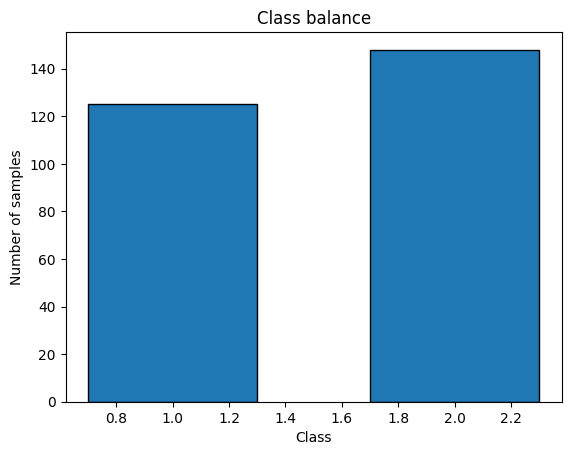

In [15]:
unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts, width=0.6, edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class balance')
plt.show()

Correlation matrix

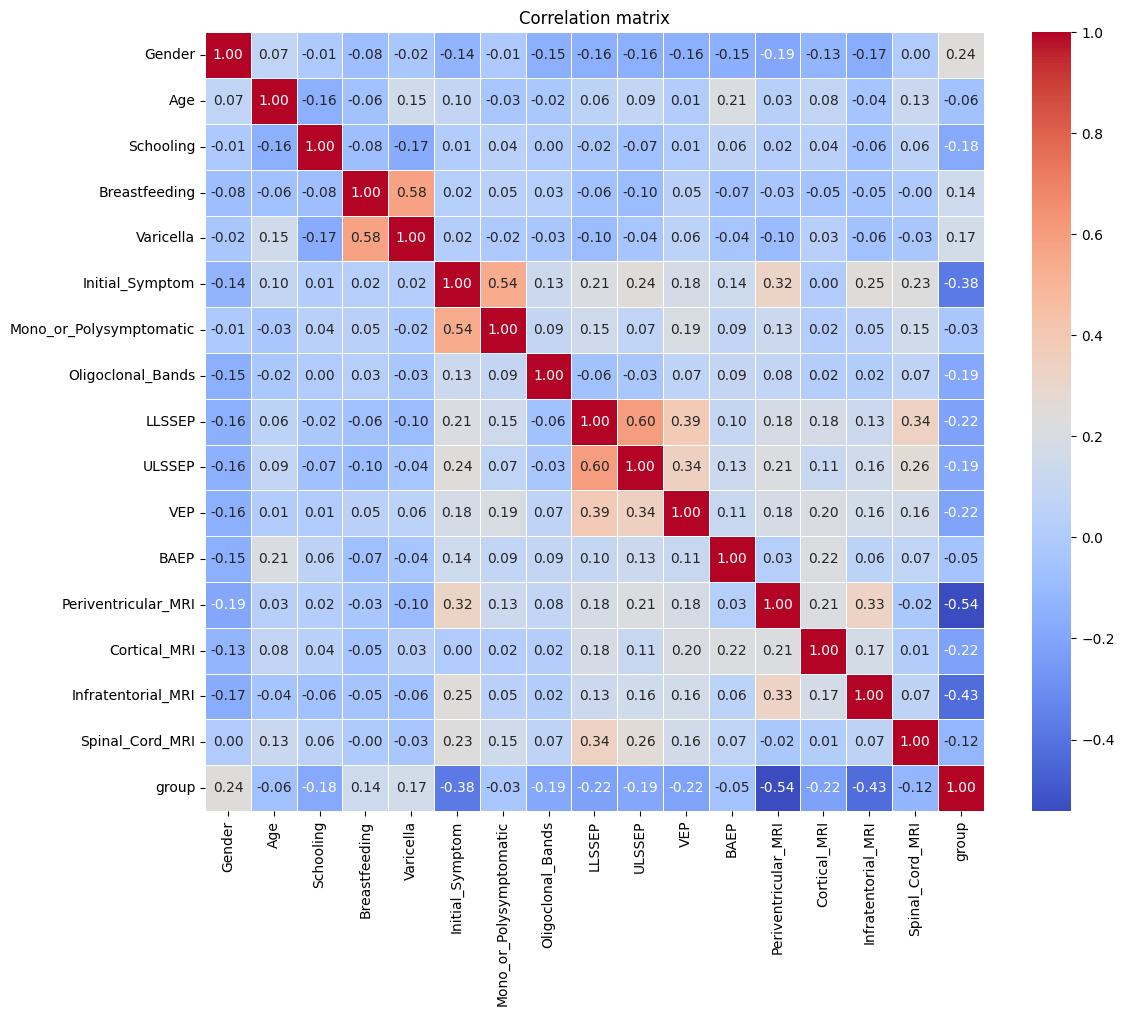

In [16]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

 Somatosensory evoked potentials (SSEP) are recorded from the central nervous system following stimulation of peripheral nerves. ULSSEP (upper limb SSEP), LLSSEP (lower limb SSEP).

 That is why they correlate, but it was decided to leave them.

## Model training

Split data

In [17]:
x = df.drop(['group'], axis=1)
y = df['group']

x_train, x_test, y_train2, y_test2 = train_test_split(x, y, test_size=0.2, random_state=42)
y_train = (y_train2 == 1).astype(int)
y_test = (y_test2 == 1).astype(int)

### Naive Bayes Classifier

In [18]:
x_train_cat = x_train.drop(['Schooling', 'Age'], axis=1)
x_test_cat = x_test.drop(['Schooling', 'Age'], axis=1)

x_train_num = x_train[['Schooling', 'Age']]
x_test_num = x_test[['Schooling', 'Age']]

gnb = GaussianNB().fit(x_train_num, y_train2)
cnb = CategoricalNB().fit(x_train_cat, y_train2)

logp_g = gnb.predict_log_proba(x_test_num)
logp_c = cnb.predict_log_proba(x_test_cat)
logp_sum = logp_g + logp_c
y_pred = np.argmax(logp_sum, axis=1) + 1

print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           1       0.77      0.88      0.82        26
           2       0.88      0.76      0.81        29

    accuracy                           0.82        55
   macro avg       0.82      0.82      0.82        55
weighted avg       0.83      0.82      0.82        55



### KNN

In [23]:
numeric_feats   = ['Age', 'Schooling']
nominal_feats   = ['Breastfeeding', 'Varicella', 'Initial_Symptom', 'Mono_or_Polysymptomatic', 'Oligoclonal_Bands']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_feats),
], remainder='passthrough')

pipe = Pipeline([
    ('prep', preprocessor),
    ('knn',  KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights':      ['uniform', 'distance'],
    'knn__metric':       ['euclidean', 'manhattan', 'cosine'],
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid.fit(x_train, y_train)

print("Best params:", grid.best_params_)
y_pred = grid.predict(x_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'knn__metric': 'cosine', 'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        29
           1       0.87      0.77      0.82        26

    accuracy                           0.84        55
   macro avg       0.84      0.83      0.83        55
weighted avg       0.84      0.84      0.84        55



### SVM

In [24]:
numeric_feats   = ['Age', 'Schooling']
nominal_feats   = ['Breastfeeding', 'Varicella', 'Initial_Symptom', 'Mono_or_Polysymptomatic', 'Oligoclonal_Bands']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_feats),
], remainder='passthrough')

svc = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=False
)

pipe = Pipeline([
    ('prep', preprocessor),
    ('svc',  svc)
])

param_grid = {
    'svc__kernel': ['rbf','linear'],
    'svc__C':      [0.1, 1, 10],
    'svc__gamma':  ['scale', 0.01, 0.1, 1],
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid.fit(x_train, y_train)

print("Best params:", grid.best_params_)
y_pred = grid.predict(x_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.81      0.76      0.79        29
           1       0.75      0.81      0.78        26

    accuracy                           0.78        55
   macro avg       0.78      0.78      0.78        55
weighted avg       0.78      0.78      0.78        55



### Logistic regression

In [36]:
numeric_feats   = ['Age', 'Schooling']
nominal_feats   = ['Breastfeeding', 'Varicella', 'Initial_Symptom', 'Mono_or_Polysymptomatic', 'Oligoclonal_Bands']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_feats),
], remainder='passthrough')

pipe = Pipeline([
    ('prep', preprocessor),
    ('clf',  LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

param_grid = {
    'clf__penalty':    ['l1', 'l2'],
    'clf__C':          [0.01, 0.1, 1, 10, 100],
    'clf__solver':     ['liblinear', 'saga'],
}


grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid.fit(x_train, y_train)

print("Best params:", grid.best_params_)
y_pred = grid.predict(x_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
              precision    recall  f1-score   support

           0       0.85      0.76      0.80        29
           1       0.76      0.85      0.80        26

    accuracy                           0.80        55
   macro avg       0.80      0.80      0.80        55
weighted avg       0.80      0.80      0.80        55



### Random forest

In [51]:
preprocessor = ColumnTransformer([
], remainder='passthrough')

pipe = Pipeline([
    ('prep', preprocessor),
    ('rf',   RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        class_weight='balanced',
        random_state=42
    ))
])


param_dist = {
    'rf__n_estimators':       [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300],
    'rf__max_depth':          randint(3, 8),
    'rf__min_samples_split':  randint(5, 20),
    'rf__min_samples_leaf':   randint(3, 10),
    'rf__max_features':       ['sqrt'],
}

rs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=300,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)


rs.fit(x_train, y_train)

print("Best params:", rs.best_params_)
y_pred = rs.predict(x_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best params: {'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 6, 'rf__min_samples_split': 16, 'rf__n_estimators': 150}
              precision    recall  f1-score   support

           0       0.81      0.72      0.76        29
           1       0.72      0.81      0.76        26

    accuracy                           0.76        55
   macro avg       0.77      0.77      0.76        55
weighted avg       0.77      0.76      0.76        55



### XGBoost

In [52]:
preprocessor = ColumnTransformer([
], remainder='passthrough')

pipe = Pipeline([
    ('prep', preprocessor),
    ('xgb',   xgb.XGBClassifier(eval_metric='logloss'))
])

param_dist = {
    'xgb__n_estimators': [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300],
    'xgb__max_depth': range(3, 8),
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9],
    'xgb__min_child_weight': [5, 6, 7, 8, 9, 10, 12, 14]
}

rs = GridSearchCV(
    estimator=pipe,
    param_grid=param_dist,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

rs.fit(x_train, y_train)
print("Best parameters:", rs.best_params_)
y_pred = rs.predict(x_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 11880 candidates, totalling 59400 fits
Best parameters: {'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 4, 'xgb__min_child_weight': 6, 'xgb__n_estimators': 100, 'xgb__subsample': 0.9}
              precision    recall  f1-score   support

           0       0.81      0.76      0.79        29
           1       0.75      0.81      0.78        26

    accuracy                           0.78        55
   macro avg       0.78      0.78      0.78        55
weighted avg       0.78      0.78      0.78        55



## Conclusion

The best model is KNN with cosine distance metric and 11 neighbors. This model has an f1 score of 0.87 and a precision value of 0.82 for class 1. Precision is more important to us in this case, since it is more important not to make a false diagnosis than to miss someone who actually has multiple sclerosis, because the patient will still undergo further tests to confirm the presence of the disease if there is suspicion.

Another good model is the Naive Bayes Classifier model which has an f1 score of 0.88 and a precision value of 0.81 for class 1.